In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
df = pd.read_csv('nvidia_stock_prices.csv')
print(df.head())
print(df.info())
print(df.describe())

         Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5033 non-null   object 
 1   Open    5033 non-null   float64
 2   High    5033 non-null   float64
 3   Low     5033 non-null   float64
 4   Close   5033 non-null   float64
 5   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.1+ KB
None
              Open         High          Low        Close        Volume
count  5033.000000  5033.000000  5033.000000  5033.000000  5.

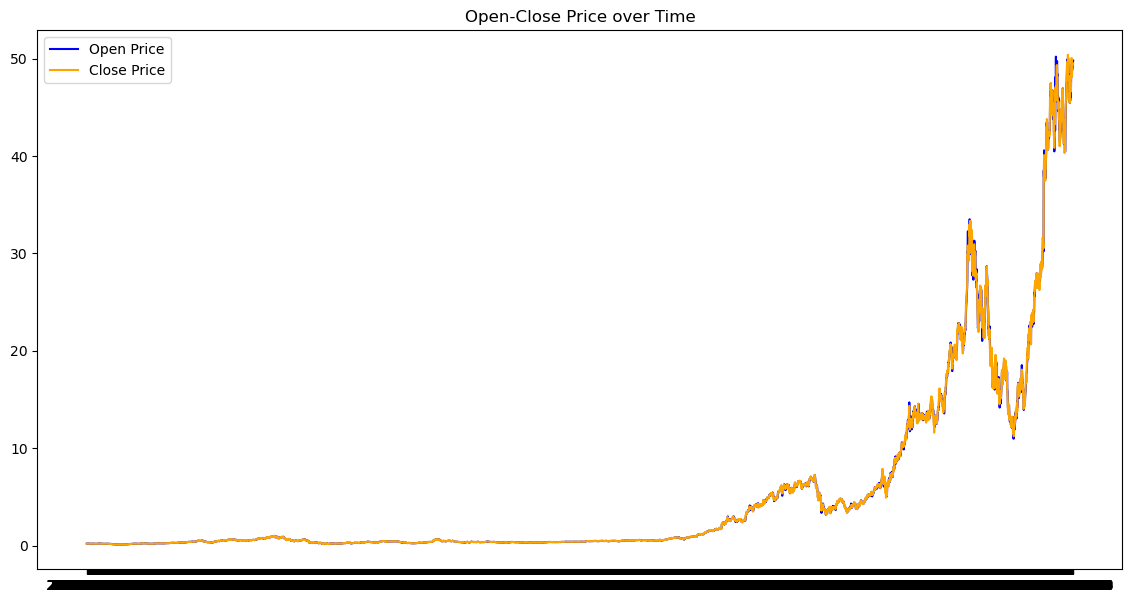

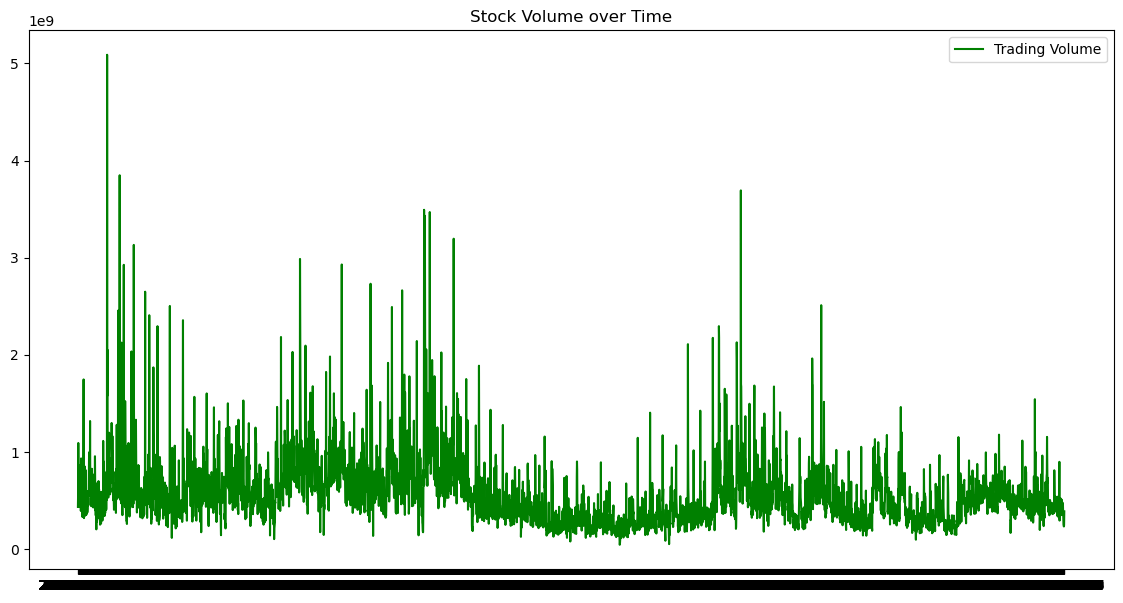

In [6]:
# initial data visualization
# Plot 1: Open and Close Prices of time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Open'], label='Open Price', color='blue')
plt.plot(df['Date'], df['Close'], label='Close Price', color='orange')
plt.title('Open-Close Price over Time')
plt.legend()
plt.show()

# Plot 2: Trading Volume (check outliers)
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Volume'], label='Trading Volume', color='green')
plt.title('Stock Volume over Time')
plt.legend()
plt.show()

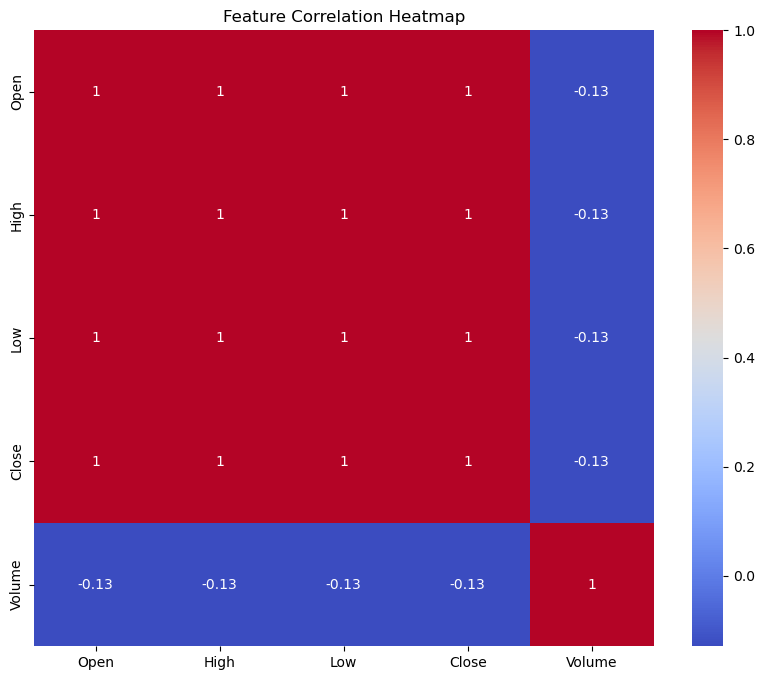

In [7]:
# drop non-numeric columns
numeric_data = df.select_dtypes(include=["int64", "float64"])

# Plot 3: check for correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Text(0.5, 1.0, 'Close Price over Time')

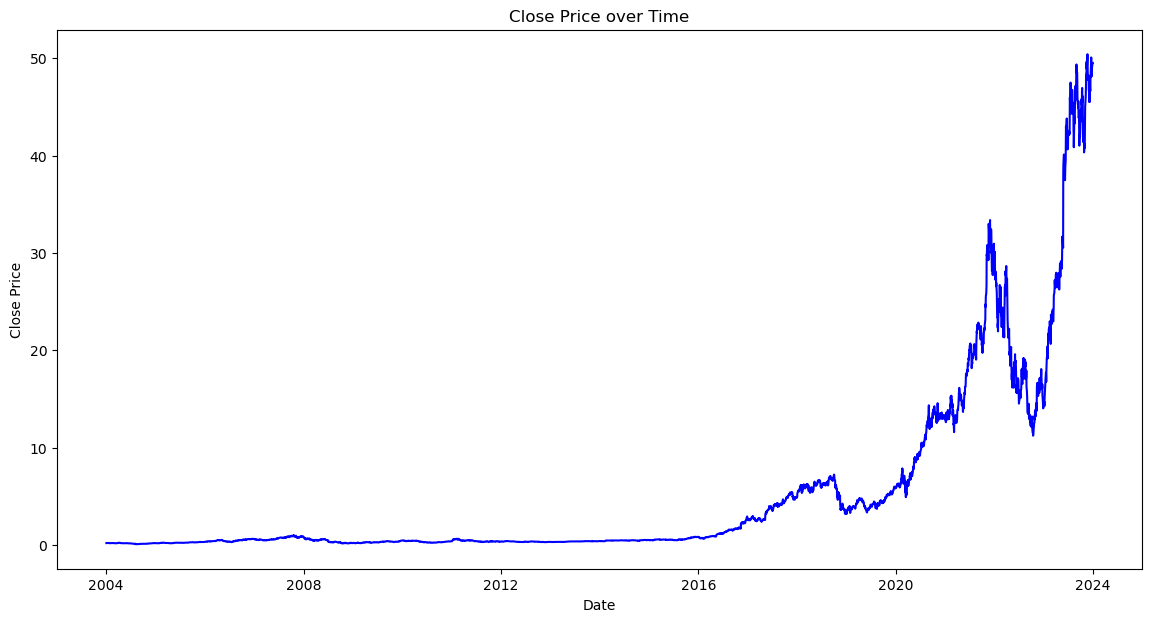

In [8]:
# convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

prediction = df.loc[
    (df['Date'] >= datetime(2013, 1, 1)) & (df['Date'] <= datetime(2023, 6, 30))
]

# Plot 1: Open and Close Prices of time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price over Time')

In [10]:
# prepare for the LSTM Model Sequential
stock_close = df.filter(["Close"])

dataset = stock_close.values # convert to numpy array

training_data_len = int(np.ceil( len(dataset) * .95 )) # 95% training data

# preprocessing stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[:training_data_len] # 95% of the data for training

X_train, y_train = [], []

# create a sliding window for stock (60 days)
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0]) # i-60, first row of data
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # convert to numpy array

# convert to 3D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshape for LSTM [samples, time steps, features]

In [13]:
# build the LSTM model
model = keras.models.Sequential()

# first layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# second layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# dense layer
model.add(keras.layers.Dense(128, activation='relu'))

# dropout layer
model.add(keras.layers.Dropout(0.5))

# final layer (dense layer)
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# train the model
train = model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.1102 - root_mean_squared_error: 0.1941
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0731 - root_mean_squared_error: 0.1163
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0644 - root_mean_squared_error: 0.1051
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0620 - root_mean_squared_error: 0.1012
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0592 - root_mean_squared_error: 0.0976
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0572 - root_mean_squared_error: 0.1005
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0549 - root_mean_squared_error: 0.1016
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0535 - root_mean_squared_error: 0.0976
Epoch 9/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0503 - root_mean_squared_error: 0.0921
Epoch 10/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0493 - root_mean_

In [15]:
# prep the test data
test_data = scaled_data[training_data_len - 60:] # last 60 days of training data + test data
X_test, y_test = [], dataset[training_data_len:] # y_test is actual stock prices (unscaled)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
# make a prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # unscale the data

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


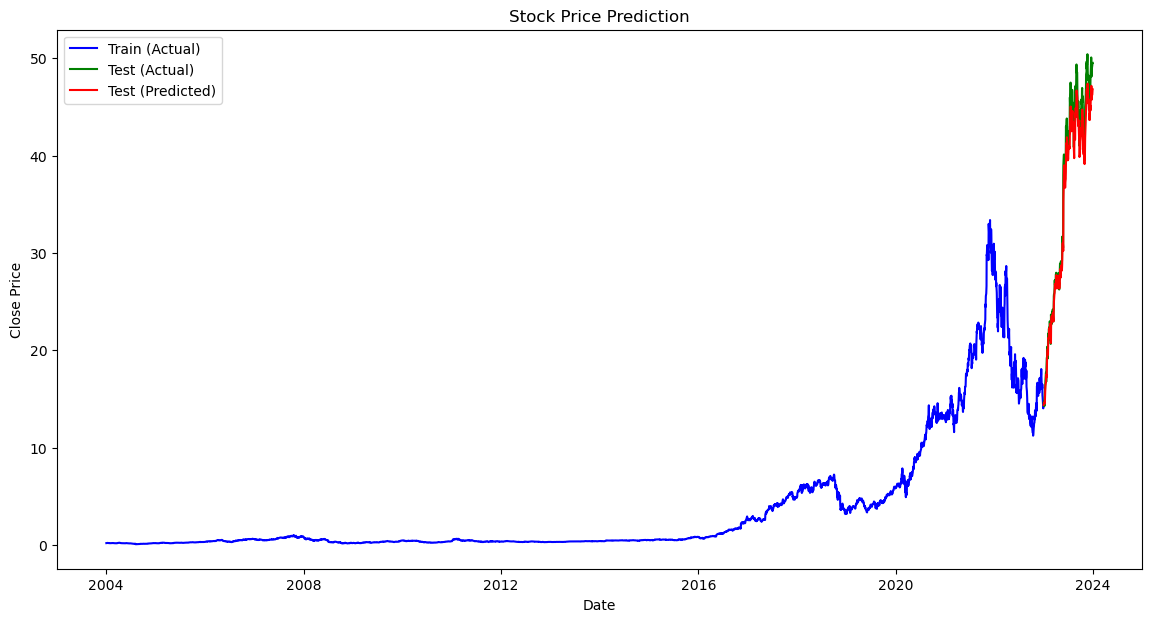

In [17]:
# plotting data
train = df[:training_data_len]
test = df[training_data_len:]

test = test.copy()

test['Predictions'] = predictions

plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Close'], label='Train (Actual)', color='blue')
plt.plot(test['Date'], test['Close'], label='Test (Actual)', color='green')
plt.plot(test['Date'], test['Predictions'], label='Test (Predicted)', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()